<a href="https://colab.research.google.com/github/Bigdata-webtoon-recommendation/webtoon-recommend/blob/main/webtoon_recommend_input_with_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np


## **[INPUT(나이 / 좋아하는 웹툰)]**
## 옵션 1: q를 입력받을 때까지 계속 받음, 3개 이상

+ 19세 이하일 경우 성인용 웹툰 data에서 삭제
+ 평점 상위 10% 에는 가중치 높게, 하위 10% 에는 가중치 낮게, 나머지는 동일

In [5]:
# 전체 네이버 + 다음 웹툰 갯수 2383개 // 네이버 1- 1181, 다음 1182 - 2383
data = pd.read_csv("./naver_daum_integration_v2.csv")
#data.last_valid_index

# 추천 점수 저장할 리스트 선언 (data의 idx(1~2383)을 인덱스로)
recommend_score = [0 for i in range(len(data)+1)]

# 나이 입력받기
age = input('나이를 입력하세요: ')

# 잘못 입력했을 경우 정확히 입력할 때까지 반복
while not age.isdigit():
    age = input('정확한 나이를 입력하세요: ')
    if age.isdigit():
        break
    
# 전체 웹툰 제목 받아오기 (input 값 비교용)
title = np.array(data['name'].tolist())

# 입력한 웹툰의 제목을 저장하는 리스트
input_list = []

# q를 입력할 때까지 좋아하는 웹툰 제목을 입력받음, 무조건 세 개 이상 입력해야함, 중복 입력 불가능
while 1:
    a = input('좋아하는 웹툰을 입력하세요(q 입력 시 종료): ')
    if a == 'q':
        if len(input_list) >= 3:
            break
        else:
            print("웹툰을 세 개 이상 입력하세요")
    elif a not in title:
        print('입력한 웹툰이 존재하지 않습니다.')
    elif a in input_list:
        print('중복된 웹툰입니다.')
    else:
        input_list.append(a)

# like_list에 입력받은 웹툰 정보를 저장, 각 요소는 Series type으로 되어있음
like_list = []
for i in input_list:
    like_list.append(data[data.name == i])

# like_list에 저장된 각 요소를 하나의 DataFrame으로 합쳐줌 -> like_df에는 입력받은 웹툰들이 DataFrame의 행 형태로 있음
like_df = like_list[0]
for i in like_list[1:]:
    like_df = pd.concat([like_df, i])

# 입력받은 나이가 19세 미만이면 19세 웹툰은 data(추천 데이터셋)에서 삭제
if int(age) < 19:
    data = data[data.age_limit != 1]
    

############ score 가중치 계산 ############

# score의 내림차순으로 정렬한 data를 score_arrange_data에 저장
score_arrange_data = data.sort_values(by=['score'], axis=0, ascending=False)

# data 개수의 10%는 238개
ten_percent = round(len(data) * 0.1)

# 상위 10%의 가장 낮은 점수(9.96)과 하위 10%의 가장 높은 점수(8.96)를 저장 (동점인 항목까지 가중치 부여에 포함하기 위함)
high_score = score_arrange_data.iloc[ten_percent - 1].score
low_score = score_arrange_data.iloc[len(data)-ten_percent].score

# score가 높은 idx(291개), score가 낮은 idx(238개)를 배열에 각각 저장
high_score_list = data[data['score'] >= high_score].index.values
low_score_list = data[data['score'] <= low_score].index.values

나이를 입력하세요: 23
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 유미의 세포들
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 간 떨어지는 동거
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 내일
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 무지개다리 파수꾼
좋아하는 웹툰을 입력하세요(q 입력 시 종료): q


# **[ 추천 알고리즘 구현 정리 ]**

* Content-based 에서 사용하는 features

  * 제목/작가/ **평점** / 연령정보 / **장르** / **키워드**
    * 작가는 추후 고려요소! (or 작가는 너무 같은작가가 별로 없는 편이니까 마지막에 top30정도 추리고 나서 가중치 둬서 올리는 식으로)

* 결론적으로 content-based에서 최종score에 반영되는것은
    * **평점(rating_score)**
    * **장르(genre_score)**
    * **키워드(story_score)**
    * **(recommend_score) = rating_score * w1 + genre_score * w2 + story_score * w3**

* (recommend_score)을 naver_daum_integration_v2.csv의 각 행, 즉 각 웹툰에 대해 모두 계산해 두어야 함

* (recommend_score) 계산한거 sorting 해서 top30 뽑은 후 적당히 작가 같은거 있으면 점수 올려주는 식으로..


## **평점별 점수 (rating_score) 계산**

[0.5 1.  1.  ... 0.5 0.5 0.5]


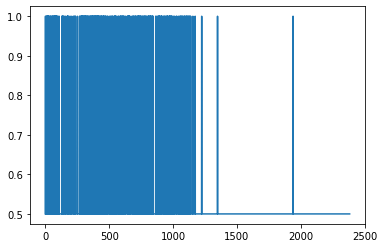

In [6]:
rating_score = np.zeros([len(data)])

# score가 높은 웹툰과 낮은 웹툰에 해당하는 idx의 recommend score 점수에 가중치 부여 (각각 1과 0)
for i in high_score_list:
    rating_score[i] += 1
    
for i in low_score_list:
    rating_score[i] = 0

for i in range (0, 2383):
  if rating_score[i] != (0 or 1):
    rating_score[i] = 0.5

print(rating_score)
plt.plot(rating_score)
plt.show()

## **장르별 유사도 점수 (genre_score) 계산**

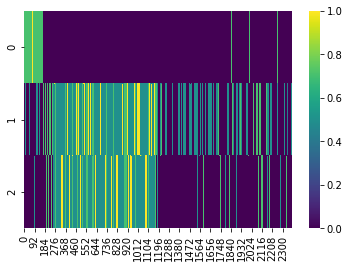

(3, 2383)

In [10]:
# 현재 모든 웹툰 데이터(naver_daum_integration_v2.csv 읽어온 데이터) 는 data라는 dataframe에 저장되어 있음
# g1, ... , g12 를 뽑아서 -> cos sim 비교
data_genre = data
data_genre = data_genre[['g1','g2','g3','g4','g5','g6','g7','g8','g9','g10','g11']]
like_df = like_df[['g1','g2','g3','g4','g5','g6','g7','g8','g9','g10','g11']]

cosine_sim_val = cosine_similarity(like_df,data_genre)

sns.heatmap(cosine_sim_val, cmap='viridis')
plt.show()

cosine_sim_val.shape


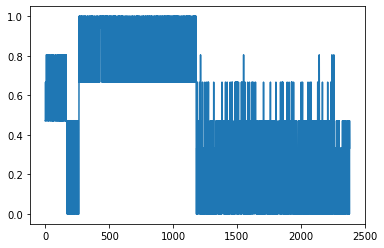

In [11]:
# 사용자가 선호하는 웹툰(n개)에 대해 각각 2380?개의 총 웹툰과의 유사도가 나온 상태.
# 즉 cosin_sim_val의 shape 는 (n, 2383)
# 웹툰 2380개에 대해 각각의 genre_score을 이 n개에서 각각 나온 score을 더해서 평균내고
# 마지막으로 normalize하여 점수 저장

cosine_sim_avg = np.zeros([len(data)])
for i in range (0, len(like_df)):
  cosine_sim_avg = cosine_sim_avg + cosine_sim_val[i]

c_max = cosine_sim_avg.max()
c_min = cosine_sim_avg.min()

cosine_sim_avg_norm = (cosine_sim_avg - c_min) / (c_max - c_min)

plt.plot(cosine_sim_avg_norm)
plt.show()

genre_score = cosine_sim_avg_norm

## **키워드 점수 (story_score) 계산**

In [22]:
story_score = np.ones([len(data)])

## **결과점수 (recommend_score) 계산**

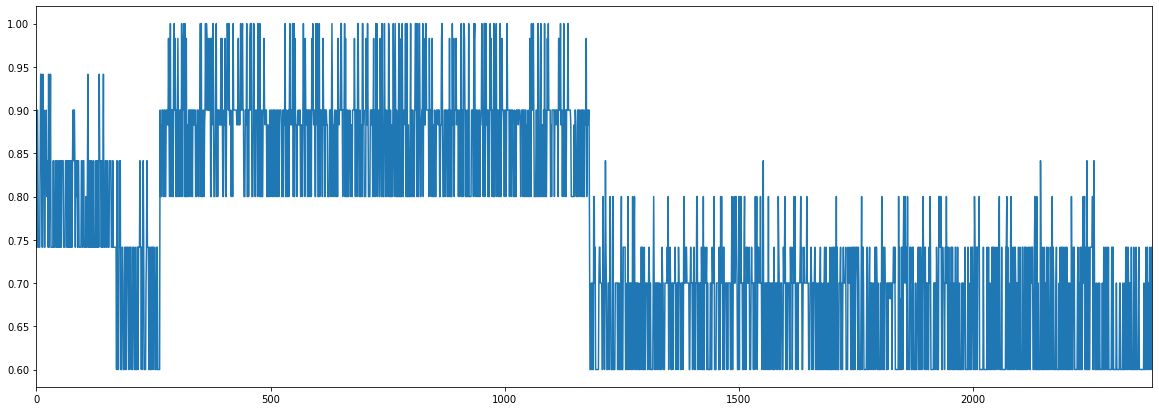

top1 index:  809
결과점수:  1.0
웹툰제목:  고인의 명복
(2383, 1)


In [31]:
# weight setting
w1 = 0.2
w2 = 0.3
w3 = 0.5

recommend_score = rating_score * w1 + genre_score * w2 + story_score * w3

# plotting
plt.figure(2, figsize = (20,7))
plt.plot(recommend_score)
plt.xlim([0,2383])
plt.show()

top1_idx = recommend_score.argsort()[-1]
print("top1 index: ", top1_idx)
print("결과점수: ",recommend_score[top1])
title = np.array(data['name'].tolist())
print("웹툰제목: ", title[top1_idx])

recommend_score = recommend_score[:,None]
print(recommend_score.shape)